Addig annotations from SNPnexus output files

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from bsmcalls import individuals
from bsmcalls import readVCF
from bsmcalls import SNPnexus
from bsmcalls import preprocessing
import pandas as pd
import numpy as np
import re
import pickle
import attila_utils
%matplotlib inline

## Annotation with SNPnexus
[SNPnexus](https://www.snp-nexus.org/v4/) is a recently updated web service that uses numerous databases to annotate human genomic variants (see [this article](https://academic.oup.com/nar/article/48/W1/W185/5851388)).  The short sections below present information regarding the way I used SNPnexus to annotate our somatic variant calls.  The following settings were used:

* Human Assembly: GRCh37/hg19
* filtered VCF files were uploaded
* all annotation categories were selected
* *TXT per annotation*

### Overlapping genes
A key annotation of *Overlapped and Nearest Genes*, stored in the `near_gens.txt` output file of SNPnexus.  Each variant is overlapped by zero, one or more genes. In the last case two or more genes overlap each other around the given variant and `near_gens.txt` lists the same variant in multiple rows corresponding to the multiple overlapping genes. Since my `calls` DataFrame must contain exactly one row for each variant I collapsed those multiple rows into one by listing the overlapping genes in a single colon (`:`) separated string.

[This article](https://www.nature.com/articles/s41598-019-49802-w) presents a study of overlapping genes and shows that sometimes more than 5 genes may overlap at a locus.  This means that for each variant I should come up with a---possibly empty---set of genes that overlap that variant.

### Selecting sets of annotations

See `notebook/2020-09-07-annotations/examine-annot-files.csv`, which lists all the annotation files and whether they were incuded in further analysis based on two criteria

1. redundance: several sets annotations provide very similar information therefore only one of those were included
2. relevance: cancer related annotations were excluded

### Implementation

See `SNPnexus.merge_snpnexus_with_other_annotations` for details

In [2]:
fulldata = SNPnexus.merge_snpnexus_with_other_annotations(calls=individuals.get_datasets(), testmode=False)

### Save data

Export `fulldata` as `annotated-calls-full.csv` or pickle dump into `annotated-calls-full.p`.

Note that `fulldata` contains superfluous sets of observations:
* NeuN_mn or muscle tissue from the Chess dataset
* low quality calls for the Walsh dataset

`SNPnexus.filter_fulldata` removes these

In [3]:
fpath = '/home/attila/projects/bsm/results/2020-09-07-annotations/annotated-calls'
fulldata.to_csv(fpath + '-full.csv')
SNPnexus.filter_fulldata(fulldata).to_csv(fpath + '.csv')

In [4]:
colnames = ['near_gens_Overlapped Gene', 'near_gens_Type', 'near_gens_Annotation', 'near_gens_Nearest Upstream Gene', 'near_gens_Type of Nearest Upstream Gene', 'near_gens_Nearest Downstream Gene', 'near_gens_Type of Nearest Downstream Gene']
fulldata = SNPnexus.multi_str2list(fulldata, colnames=colnames, nonestr='None', sepstr=':')

In [5]:
pickle.dump(fulldata, open(fpath + '-full.p', 'wb'))
fulldata.shape

(11824, 136)

In [6]:
data = SNPnexus.filter_fulldata(fulldata)
pickle.dump(data, open(fpath + '.p', 'wb'))
data.shape

(6426, 136)

### How to load data?

See implementation: `SNPnexus.load_data()`

In [7]:
fpath = '/home/attila/projects/bsm/results/2020-09-07-annotations/annotated-calls.p'
with open(fpath, 'rb') as f:
    data = pickle.load(f)

Dummify numeric variables in order to calculate correlation matrix

In [8]:
datanum = preprocessing.dummify_df(data)
list(datanum.columns)

['AF',
 'BaseQRankSum',
 'DP',
 'FS',
 'SOR',
 'VQSLOD',
 'szdbCNVcount',
 'GWASpval',
 'ageOfDeath',
 'Brain Weight (in grams)',
 'PMI (in hours)',
 'Year of Autopsy',
 'EV.1',
 'EV.2',
 'EV.3',
 'EV.4',
 'EV.5',
 '1KGen_dbSNP',
 '1KGen_REF Allele',
 '1KGen_ALT Allele',
 '1KGen_Minor Allele',
 '1KGen_AFR Frequency',
 '1KGen_AFR Frequency_bin',
 '1KGen_AMR Frequency',
 '1KGen_AMR Frequency_bin',
 '1KGen_EAS Frequency',
 '1KGen_EAS Frequency_bin',
 '1KGen_EUR Frequency',
 '1KGen_EUR Frequency_bin',
 '1KGen_SAS Frequency',
 '1KGen_SAS Frequency_bin',
 'cpg_Region Start',
 'cpg_Region End',
 'cpg_CpG Island',
 'cpg_CpG Island_bin',
 'cpg_Length',
 'cpg_CpG %',
 'cpg_C/G %',
 'cpg_Ratio',
 'deepsea_Variant',
 'deepsea_Functional Significance Score',
 'deepsea_eQTL Probability',
 'deepsea_GWAS Probability',
 'deepsea_HGMD Probability',
 'encode_Region Start',
 'encode_Region End',
 'encode_Feature Type',
 'encode_Epigenome',
 'ensembl_Variant',
 'ensembl_Strand',
 'ensembl_Symbol',
 'ensemb

In [9]:
def corrmatplot(dfnum):
    corrmat = dfnum.corr()
    fig, ax = plt.subplots(figsize=(8,8))
    sm.graphics.plot_corr(corrmat, ax=ax, xnames=dfnum.columns, ynames=dfnum.columns)
    cb = plt.colorbar(ax.get_images()[0])
    cb.set_label('Correlation')
    return((fig, ax))

['named-figure/corr-mat-snpnexus.png', 'named-figure/corr-mat-snpnexus.pdf']

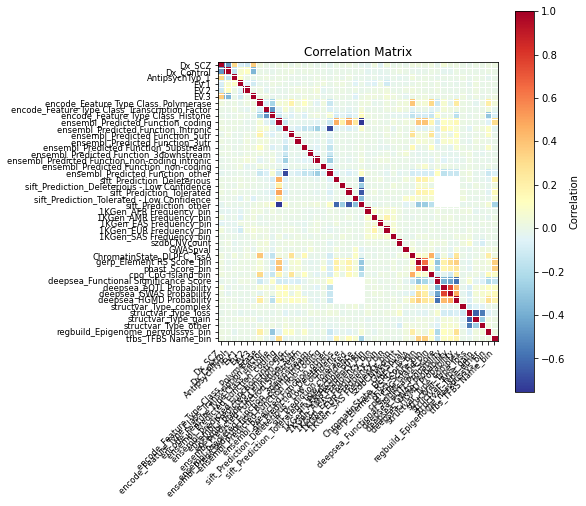

In [10]:
sel_cols = ['Dx_SCZ', 'Dx_Control', 'AntipsychTyp_1', 'EV.1', 'EV.2', 'EV.3']
sel_cols += ['encode_Feature Type Class_Polymerase', 'encode_Feature Type Class_Transcription Factor', 'encode_Feature Type Class_Histone']
sel_cols += ['ensembl_Predicted Function_coding', 'ensembl_Predicted Function_intronic', 'ensembl_Predicted Function_5utr', 'ensembl_Predicted Function_3utr', 'ensembl_Predicted Function_5upstream', 'ensembl_Predicted Function_3downstream', 'ensembl_Predicted Function_non-coding intronic', 'ensembl_Predicted Function_non-coding', 'ensembl_Predicted Function_other']
sel_cols += ['sift_Prediction_Deleterious', 'sift_Prediction_Deleterious - Low Confidence', 'sift_Prediction_Tolerated', 'sift_Prediction_Tolerated - Low Confidence', 'sift_Prediction_other']
sel_cols += ['1KGen_AFR Frequency_bin', '1KGen_AMR Frequency_bin', '1KGen_EAS Frequency_bin', '1KGen_EUR Frequency_bin', '1KGen_SAS Frequency_bin']
sel_cols += ['szdbCNVcount','GWASpval', 'ChromatinState_DLPFC_TssA']
sel_cols += ['gerp_Element RS Score_bin', 'phast_Score_bin']
sel_cols += ['cpg_CpG Island_bin']
sel_cols += ['deepsea_Functional Significance Score', 'deepsea_eQTL Probability', 'deepsea_GWAS Probability', 'deepsea_HGMD Probability']
sel_cols += ['structvar_Type_complex', 'structvar_Type_loss', 'structvar_Type_gain', 'structvar_Type_other']
sel_cols += ['regbuild_Epigenome_nervoussys_bin']
sel_cols += ['tfbs_TFBS Name_bin']
fig, ax = corrmatplot(datanum[sel_cols])
attila_utils.savefig(fig, 'corr-mat-snpnexus')

['named-figure/corr-Dx-snpnexus.png', 'named-figure/corr-Dx-snpnexus.pdf']

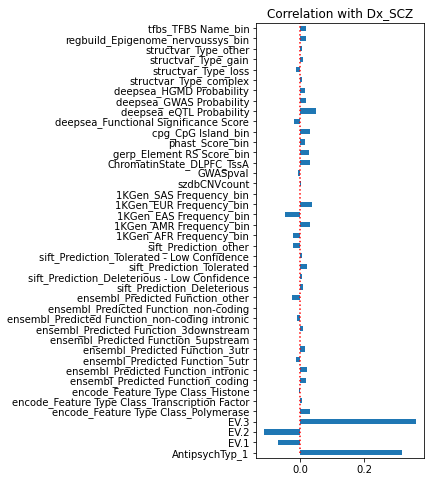

In [11]:
fig = plt.figure(figsize=(3,8))
s = datanum.corr().loc[sel_cols, 'Dx_SCZ'][2:]
ax = s.plot.barh()
ax.vlines(x=0, ymin=0, ymax=len(sel_cols), colors='red', linestyles='dotted')
ax.set_title('Correlation with Dx_SCZ')
attila_utils.savefig(fig, 'corr-Dx-snpnexus')

### Evolutionary constraints

Four evolutionary conservation scores by three methods are compared to each other below

* gerp++ has two RS (rejected substitution) scores
* `gerp_Element RS Score` refers to conservative elements while `gerp_Base RS Score` to conservative bases

The missing plots illustrated the relationship between `phast_Score` and `gerp_Element RS Score` (left) as well as that between `gerp_Base vs gerp_Element` and `gerp_Element RS Score` (right).

## Andy's questions

* Roadmap epigenome annotation of SNPnexus: what does it exactly mean?
* mutation types (A/C, ...): how does the mutational spectrum in the outlier sample compare to that in other samples?
* brain expressed genes combined with chromatin state DLPFC
* control callsets from other BSMN groups

In [12]:
%connect_info

{
  "shell_port": 44057,
  "iopub_port": 59293,
  "stdin_port": 37579,
  "control_port": 46529,
  "hb_port": 33511,
  "ip": "127.0.0.1",
  "key": "2d7d0c72-6ea34eebf4e26dbdf21fff50",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-f8633471-04f8-471c-9103-bf979727cc1c.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
